# Data Science
# Exercise 2 (Part 1/2: Small Data Set)
<br/>se21m024
<br/>Thomas Stummer
<br/>Small Dataset: Heart Disease
<br/><br/>
*The interpretation of the data can be found in the document <b><i>se21m024_Stummer_ex2_Dim_Reduction.pdf</i><b>.
<br/><br/>
Data taken from:
<br/>https://archive.ics.uci.edu/ml/datasets/Heart+Disease
<br/><br/>
Data Creators:
1. Hungarian Institute of Cardiology. Budapest: Andras Janosi, M.D.
2. University Hospital, Zurich, Switzerland: William Steinbrunn, M.D.
3. University Hospital, Basel, Switzerland: Matthias Pfisterer, M.D.
4. V.A. MediMcal Center, Long Beach and Cleveland Clinic Foundation: Robert Detrano, M.D., Ph.D.

# Import necessary dependencies

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
import numpy as np
import seaborn as sns
import math as math
import itertools as it
from sklearn.manifold import MDS
import sklearn.datasets as dt
from sklearn.metrics.pairwise import manhattan_distances, euclidean_distances
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pd.options.display.max_columns = None

%matplotlib inline

# Load and merge datasets

In [13]:
# Only examine processed data with a subset of 14 attributes

columns = [
    'Age', 'Sex', 'Chest Pain Type', 'Resting Blood Pressure', 'Serum Cholestoral', 
    'Increased Blood Sugar', 'Electrocardiographic', 'Peak Heart Rate', 'Angina', 
    'ST depression', 'Peak Exercise ST Segment', 'Major Vessels', 'Thal', 'Diagnosis']

cleveland_raw_data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data', sep=',', names = columns, skipinitialspace=True)
hungarian_raw_data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.hungarian.data', sep=',', names = columns, skipinitialspace=True)
switzerland_raw_data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.switzerland.data', sep=',', names = columns, skipinitialspace=True)
va_raw_data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.va.data', sep=',', names = columns, skipinitialspace=True)

raw_data = pd.concat([cleveland_raw_data, hungarian_raw_data, switzerland_raw_data, va_raw_data])

# re-shuffle records just to randomize data points
raw_data = raw_data.sample(frac=1, random_state=42).reset_index(drop=True)
raw_data.head()


,Age,Sex,Chest Pain Type,Resting Blood Pressure,Serum Cholestoral,Increased Blood Sugar,Electrocardiographic,Peak Heart Rate,Angina,ST depression,Peak Exercise ST Segment,Major Vessels,Thal,Diagnosis
0,36.0,1.0,2.0,120,166,0,0,180,0,0.0,?,?,?,0
1,45.0,1.0,2.0,140,224,1,0,122,0,0.0,?,?,?,0
2,48.0,1.0,4.0,160,329,0,0,92,1,1.5,2,?,?,1
3,59.0,1.0,4.0,164.0,176.0,1.0,2.0,90.0,0.0,1.0,2.0,2.0,6.0,3
4,40.0,0.0,4.0,150,392,0,0,130,0,2.0,2,?,6,1


# Filter and transform features

In [14]:
data=raw_data

### Helper functions

def roundElementToIntSafe(y):
    try:
        return int(float(y))
    except:
        return None

def roundToInt(x):
    return x.apply(lambda value: roundElementToIntSafe(value))

def parseFloatElementSafe(y):
    try:
        return float(y)
    except:
        return None

def parseFloat(x):
    return x.apply(lambda value: parseFloatElementSafe(value)) 


### Parse columns, assign categories, remove invalid records

numericalColumns = []
categoryColumns = []
numericalCategoryColumns = []

def processColumn(data, column, isFloat=False, categoryMapping=None, categories=None):

    # Parse
    if not isFloat:
        data[column] = roundToInt(data[column])
    else:
        data[column] = parseFloat(data[column])

    # (optional) Filter records that contain one or more invalid columns
    data = data.drop(data[data[column].isnull()].index)

    # Append to global array
    if categoryMapping is None:
        numericalColumns.append(column)
    else:
        numericalCategoryColumns.append(column)
        categoryColumn = column
        categoryColumns.append(categoryColumn)
        data[categoryColumn] = data[column].apply(categoryMapping)
    	
        # (optional) Filter records that contain one or more invalid columns
        data = data.drop(data[data[categoryColumn].isnull()].index)

        # Add category
        data[categoryColumn] = pd.Categorical(data[categoryColumn], categories=categories)

    return data

# Age
processColumn(data=data, column='Age')

# Sex
data = processColumn(data=data, column='Sex',
categoryMapping=(lambda value: 'male' if value == 1 else 'female' if value == 0 else None), 
categories=['male', 'female'])

# Chest Pain Type
data = processColumn(data=data, column='Chest Pain Type',
categoryMapping=(lambda value: 'typical angina' if value == 1 else 'atypical angina' if value == 2 else 'non-anginal pain' if value == 3 else 'asymptomatic' if value == 4 else None), 
categories=['typical angina', 'atypical angina', 'non-anginal pain', 'asymptomatic'])

#  Resting Blood Pressure [mm Hg] (in mm Hg on admission to the hospital) 
data = processColumn(data=data, column='Resting Blood Pressure')

# Serum Cholestoral in mg/dl 
data = processColumn(data=data, column='Serum Cholestoral')
# Fix Serum Cholestoral = 0
data['Serum Cholestoral'] = data['Serum Cholestoral'].apply(lambda value: value if value > 0 else None)

# Fasting Blood Sugar > 120 mg/dl
data = processColumn(data=data, column='Increased Blood Sugar',
categoryMapping=(lambda value: 'True' if value == 1 else 'False' if value == 0 else None), 
categories=['True', 'False'])

# Resting Electrocardiographic Results
data = processColumn(data=data, column='Electrocardiographic',
categoryMapping=(lambda value: 'normal' if value == 0 else 'abnormality' if value == 1 else 'hypertrophy' if value == 2 else None),
categories=['normal', 'abnormality', 'hypertrophy'])

# Maximum Heart Rate achieved 
data = processColumn(data=data, column='Peak Heart Rate')

# Exercise induced Angina
data = processColumn(data=data, column='Angina',
categoryMapping=(lambda value: 'Yes' if value == 1 else 'No' if value == 0 else None),
categories=['Yes', 'No'])

# ST depression induced by exercise relative to rest 
data = processColumn(data=data, column='ST depression', isFloat=True)

# Slope of the peak exercise ST segment
data = processColumn(data=data, column='Peak Exercise ST Segment',
categoryMapping=(lambda value: 'upsloping' if value == 1 else 'flat' if value == 2 else 'downsloping' if value == 3 else None), 
categories=['upsloping', 'flat', 'downsloping'])

# Number of major vessels (0-3) colored by flourosopy
data = processColumn(data=data, column='Major Vessels')

# Thal
data = processColumn(data=data, column='Thal',
categoryMapping=(lambda value: 'normal' if value == 3 else 'fixed defect' if value == 6 else 'reversable defect' if value == 7 else None),
categories=['normal', 'fixed defect', 'reversable defect'])

# Diagnosis of heart disease (angiographic disease status)
data = processColumn(data=data, column='Diagnosis',
categoryMapping=(lambda value: '< 50% diameter narrowing' if value == 0 else '> 50% diameter narrowing' if value == 1 else None), 
categories=['< 50% diameter narrowing', '> 50% diameter narrowing'])

#data.head()

# Convert to categories
for column in categoryColumns:
    data[column] = pd.factorize(data[column])[0] + 1

#data.head(5)

def parseFloatElementSafe(y):
    try:
        return float(y)
    except:
        return None

def parseFloat(x):
    return x.apply(lambda value: parseFloatElementSafe(value)) 

data = data.apply(parseFloat) 
data = data.dropna()
data_array = data.to_numpy()
print("Number of data points: " + str(len(data_array)))
print(data_array)



Number of data points: 216
[[65.  1.  1. ...  0.  1.  1.]
 [69.  1.  2. ...  2.  1.  1.]
 [47.  2.  1. ...  0.  1.  1.]
 ...
 [64.  2.  2. ...  0.  1.  1.]
 [61.  2.  4. ...  1.  2.  2.]
 [57.  1.  4. ...  1.  1.  1.]]


# Algorithm 1: PCA


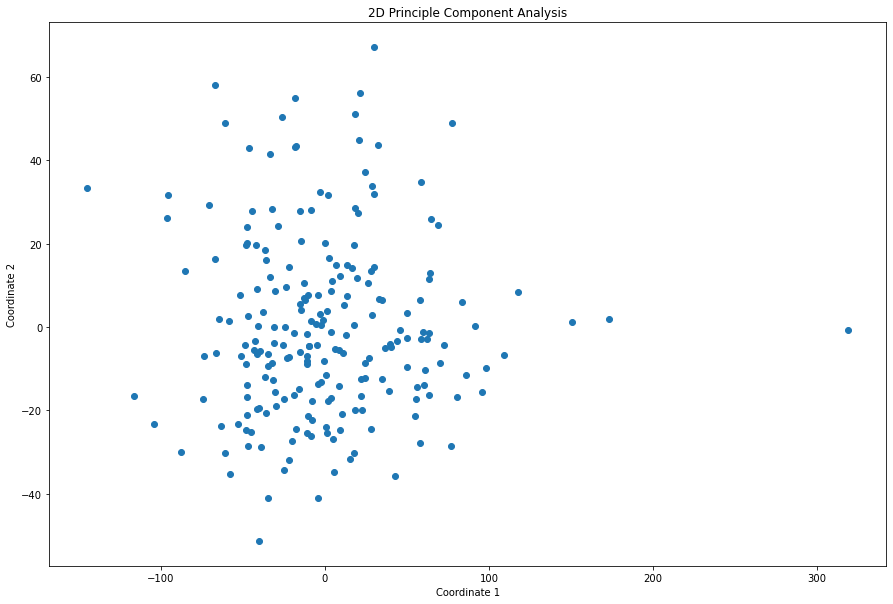

The principle component 1 accounts for 76.7% of the variance in the data set, whereas principle component 2 accounts for 13.5% of the variance. This sums up to 90.2%.


In [15]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(data_array)
principal_df = pd.DataFrame(data = principal_components)
principle_array = principal_df.to_numpy()

fig = plt.figure(2, (15,10))
plt.scatter(principle_array[:,0], principle_array[:,1])
plt.title('2D Principle Component Analysis')
plt.xlabel("Coordinate 1")
plt.ylabel("Coordinate 2")
plt.show()

pc_1_variance = round(pca.explained_variance_ratio_[0] * 100, 1)
pc_2_variance = round(pca.explained_variance_ratio_[1] * 100, 1)

print("The principle component 1 accounts for " + str(pc_1_variance) + "% of the variance in the data set, whereas principle component 2 accounts for " + str(pc_2_variance) + "% of the variance. This sums up to " + str(pc_1_variance + pc_2_variance) + "%.")


# Algorithm 2: MDS


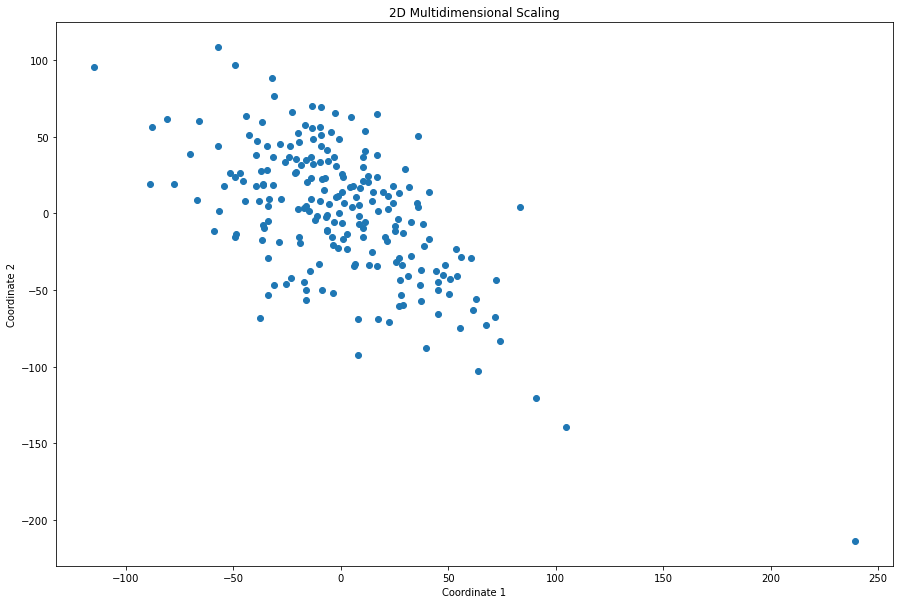

In [16]:
mds = MDS(random_state=0)
principal_components = mds.fit_transform(data_array)
principal_df = pd.DataFrame(data = principal_components)
principle_array = principal_df.to_numpy()

fig = plt.figure(2, (15,10))
plt.scatter(principle_array[:,0], principle_array[:,1])
plt.title('2D Multidimensional Scaling')
plt.xlabel("Coordinate 1")
plt.ylabel("Coordinate 2")
plt.show()

# Algorithm 3: t-SNE


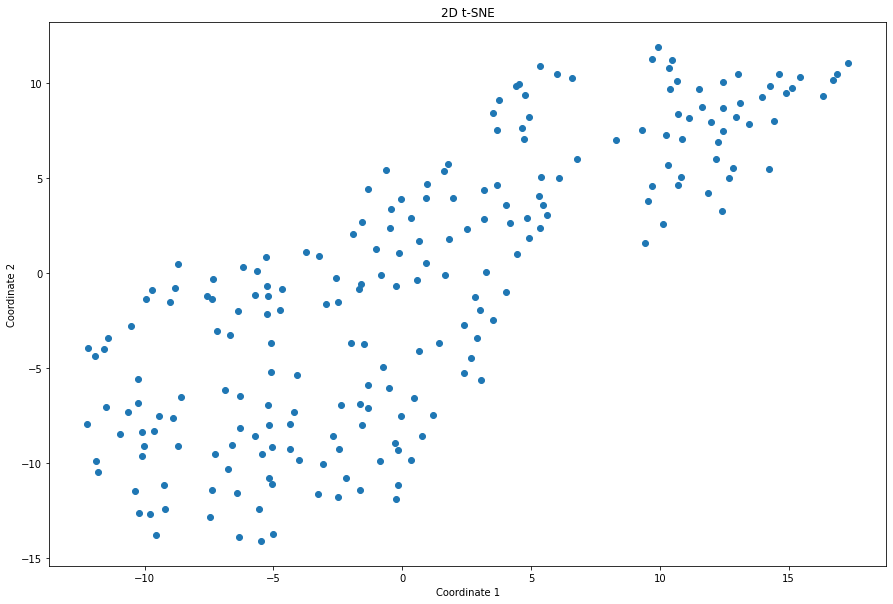

In [17]:
tsne = TSNE(n_components=2, random_state=123)
principal_components = tsne.fit_transform(data_array)
principal_df = pd.DataFrame(data = principal_components)
principle_array = principal_df.to_numpy()

fig = plt.figure(2, (15,10))
plt.scatter(principle_array[:,0], principle_array[:,1])
plt.title('2D t-SNE')
plt.xlabel("Coordinate 1")
plt.ylabel("Coordinate 2")
plt.show()